In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow import keras
### hack tf-keras to appear as top level keras
import sys
sys.modules['keras'] = keras
### end of hack

import keras.backend as K
from keras.utils import multi_gpu_model
from keras.callbacks import TensorBoard

from sklearn.model_selection import KFold

import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from keras.callbacks import *
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pprint
import os
from os import listdir
from os.path import isfile, join
from datetime import datetime

from sklearn.metrics import confusion_matrix

from keras.utils import plot_model
import matplotlib.pyplot as plt

# Importing custom framework
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from data_split import prepare_data_spectrogram, return_generators

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
def plot_confusion_matrix(cm,
                          target_names=[0,1,2,3,4,5,6,7,8,9],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
def build_cnn():
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        #keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [4]:
spectrogramPath = '../../merged/spectrogram.hdf5'
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_spectrogram(spectrogramPath, False)
print(X_train.shape)
X_train = tf.transpose(X_train, [0, 2, 3, 1])
X_val = tf.transpose(X_val, [0, 2, 3, 1])
X_test = tf.transpose(X_test, [0, 2, 3, 1])

(18000, 1, 227, 227)


In [5]:
import gc
gc.collect()
K.clear_session()
tf.compat.v1.reset_default_graph()

In [6]:
tbCallBack = TensorBoard(log_dir='logs', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

# Experiment 1

In [7]:
model = build_cnn()
plot_model(model, to_file='CNN_Experiment1.png', show_shapes=True, show_layer_names=True)
opt = SGD(lr=0.001, momentum=0.9, clipvalue=5)

In [8]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 272s 483ms/step - loss: 1.9012 - accuracy: 0.2926 - val_loss: 1.0576 - val_accuracy: 0.6807
Epoch 2/100
563/563 [==============================] - 272s 483ms/step - loss: 0.5392 - accuracy: 0.8159 - val_loss: 0.6242 - val_accuracy: 0.8343
Epoch 3/100
563/563 [==============================] - 271s 482ms/step - loss: 0.2629 - accuracy: 0.9129 - val_loss: 0.5588 - val_accuracy: 0.8270
Epoch 4/100
563/563 [==============================] - 271s 481ms/step - loss: 0.1766 - accuracy: 0.9419 - val_loss: 0.4320 - val_accuracy: 0.8802
Epoch 5/100
563/563 [==============================] - 271s 481ms/step - loss: 0.1288 - accuracy: 0.9570 - val_loss: 0.4311 - val_accuracy: 0.8842
Epoch 6/100
563/563 [==============================] - 271s 480ms/step - loss: 0.0882 - accuracy: 0.9717 - val_loss: 0.3185 - val_accuracy: 0.9142
Epoch 7/100
563/563 [==============================] - 271s 481ms/step - loss: 0.0767 - accuracy: 0.9751 - val_loss: 0

563/563 [==============================] - 269s 478ms/step - loss: 0.0033 - accuracy: 0.9989 - val_loss: 0.2388 - val_accuracy: 0.9682
Epoch 57/100
563/563 [==============================] - 269s 477ms/step - loss: 0.0012 - accuracy: 0.9993 - val_loss: 0.2644 - val_accuracy: 0.9682
Epoch 58/100
563/563 [==============================] - 269s 477ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.2621 - val_accuracy: 0.9680
Epoch 59/100
563/563 [==============================] - 269s 477ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.3927 - val_accuracy: 0.9570
Epoch 60/100
563/563 [==============================] - 268s 477ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.2809 - val_accuracy: 0.9625
Epoch 61/100
563/563 [==============================] - 269s 477ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.2571 - val_accuracy: 0.9683
Epoch 62/100
563/563 [==============================] - 269s 477ms/step - loss: 9.7671e-04 - accuracy: 0.9997 - val_loss: 0.2

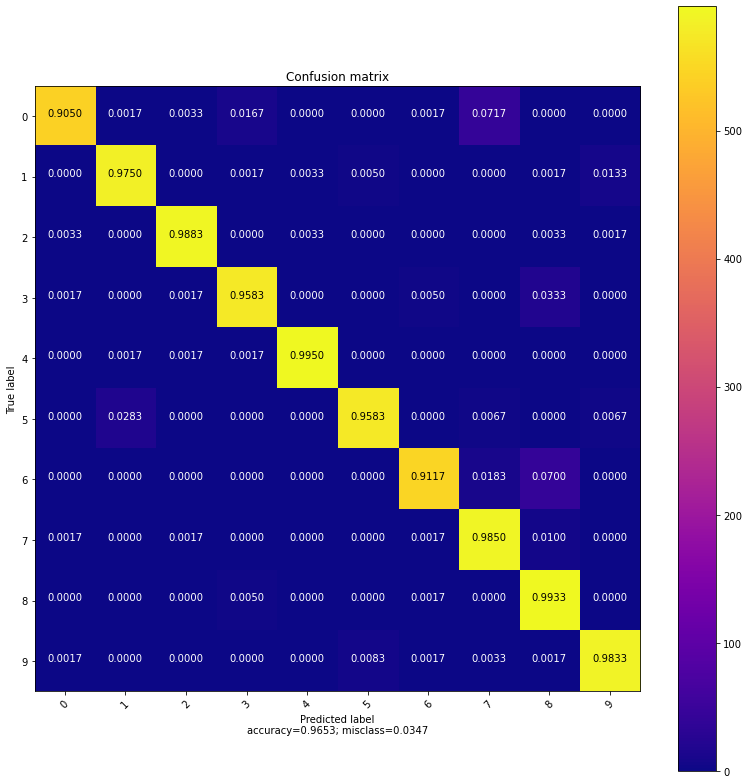

In [9]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [10]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.15978826582431793, 0.9683333039283752]


# Experiment 2

In [11]:
model = build_cnn()
#plot_model(model, to_file='CNN_Experiment2.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.001)

In [12]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 267s 474ms/step - loss: 2.4019 - accuracy: 0.0919 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
563/563 [==============================] - 267s 475ms/step - loss: 2.3031 - accuracy: 0.0932 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
563/563 [==============================] - 267s 475ms/step - loss: 2.3031 - accuracy: 0.0950 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
563/563 [==============================] - 267s 474ms/step - loss: 2.3030 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
563/563 [==============================] - 268s 475ms/step - loss: 2.3029 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
563/563 [==============================] - 267s 474ms/step - loss: 2.3029 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
563/563 [==============================] - 267s 474ms/step - loss: 2.3029 - accuracy: 0.0974 - val_loss: 2

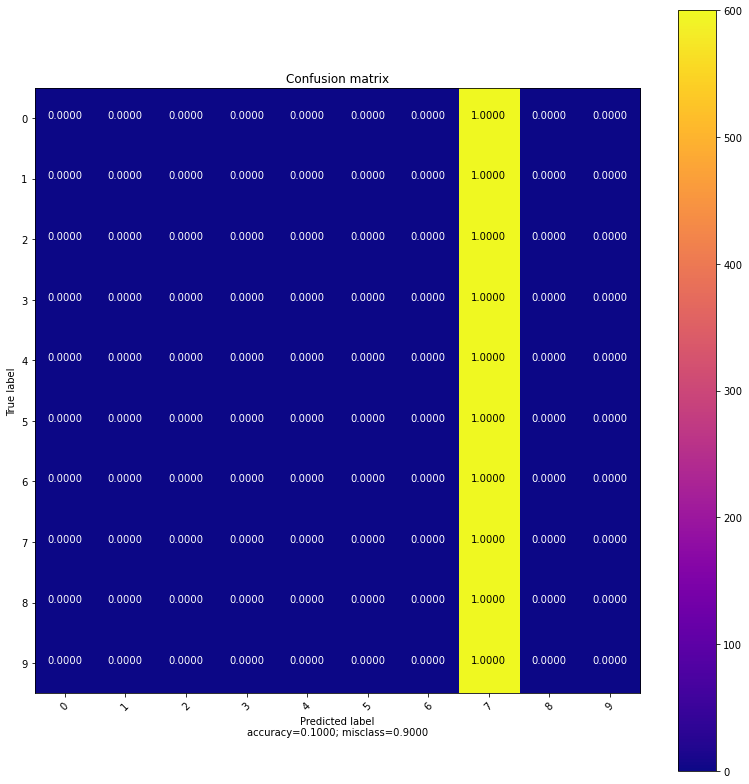

In [13]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [14]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.3025858402252197, 0.10000000149011612]


# Experiment 3

In [16]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.001)

In [17]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 199s 354ms/step - loss: 2.3230 - accuracy: 0.0964 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
563/563 [==============================] - 198s 352ms/step - loss: 2.3036 - accuracy: 0.0954 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
563/563 [==============================] - 199s 353ms/step - loss: 2.3031 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
563/563 [==============================] - 198s 351ms/step - loss: 2.3032 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
563/563 [==============================] - 198s 351ms/step - loss: 2.3030 - accuracy: 0.0958 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3030 - accuracy: 0.0944 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
563/563 [==============================] - 198s 352ms/step - loss: 2.3030 - accuracy: 0.0908 - val_loss: 2

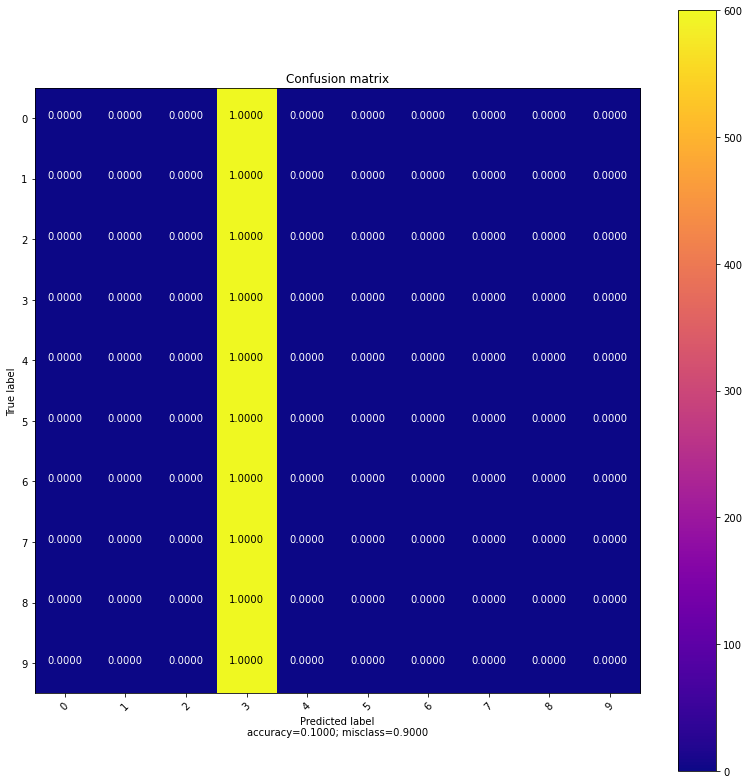

In [18]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [19]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.302586793899536, 0.10000000149011612]


# Experiment 4

In [20]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.01)

In [21]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 197s 350ms/step - loss: 1404.7007 - accuracy: 0.0891 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3071 - accuracy: 0.0824 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3044 - accuracy: 0.0814 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3037 - accuracy: 0.0818 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/100
563/563 [==============================] - 198s 351ms/step - loss: 2.3038 - accuracy: 0.0819 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/100
563/563 [==============================] - 197s 350ms/step - loss: 2.3038 - accuracy: 0.0824 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/100
563/563 [==============================] - 197s 351ms/step - loss: 2.3038 - accuracy: 0.0818 - val_loss

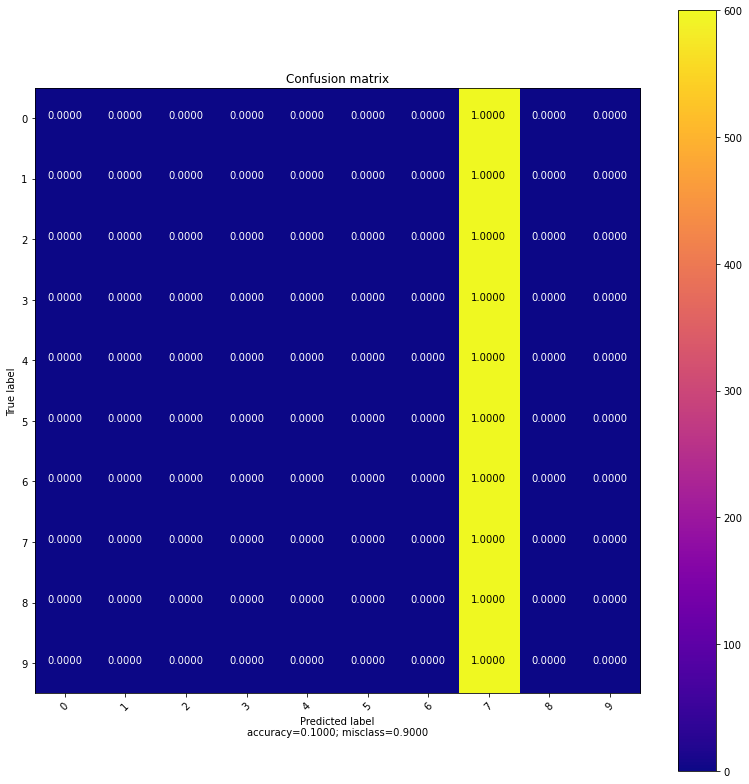

In [22]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [23]:
print(model.evaluate(X_test, y_test, verbose=0))

[2.3026018142700195, 0.10000000149011612]


# Experiment 5

In [24]:
model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
#plot_model(model, to_file='CNN_Experiment3.png', show_shapes=True, show_layer_names=True)
opt = Adam(learning_rate=0.0001)

In [25]:
K.clear_session()
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

filepath = "logs/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

training_history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),batch_size=32, callbacks=[earlyStopping, tbCallBack], shuffle=False)

val_scores = model.evaluate(X_val, y_val, verbose=0)
print(val_scores)

Epoch 1/100
563/563 [==============================] - 197s 349ms/step - loss: 1.3374 - accuracy: 0.4911 - val_loss: 0.7505 - val_accuracy: 0.7865
Epoch 2/100
563/563 [==============================] - 196s 349ms/step - loss: 0.2157 - accuracy: 0.9337 - val_loss: 0.4984 - val_accuracy: 0.8635
Epoch 3/100
563/563 [==============================] - 197s 349ms/step - loss: 0.0698 - accuracy: 0.9798 - val_loss: 0.3370 - val_accuracy: 0.9212
Epoch 4/100
563/563 [==============================] - 196s 349ms/step - loss: 0.0703 - accuracy: 0.9797 - val_loss: 0.3213 - val_accuracy: 0.9157
Epoch 5/100
563/563 [==============================] - 196s 349ms/step - loss: 0.0387 - accuracy: 0.9890 - val_loss: 0.2901 - val_accuracy: 0.9360
Epoch 6/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0354 - accuracy: 0.9895 - val_loss: 0.3738 - val_accuracy: 0.9308
Epoch 7/100
563/563 [==============================] - 197s 349ms/step - loss: 0.0266 - accuracy: 0.9924 - val_loss: 0

563/563 [==============================] - 197s 349ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.3551 - val_accuracy: 0.9742
Epoch 57/100
563/563 [==============================] - 196s 349ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.3726 - val_accuracy: 0.9685
Epoch 58/100
563/563 [==============================] - 196s 348ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.5701 - val_accuracy: 0.9578
Epoch 59/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0112 - accuracy: 0.9974 - val_loss: 0.2724 - val_accuracy: 0.9642
Epoch 60/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0174 - accuracy: 0.9968 - val_loss: 0.3417 - val_accuracy: 0.9725
Epoch 61/100
563/563 [==============================] - 197s 350ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.3845 - val_accuracy: 0.9780
Epoch 62/100
563/563 [==============================] - 197s 351ms/step - loss: 2.3079e-05 - accuracy: 1.0000 - val_loss: 0.3

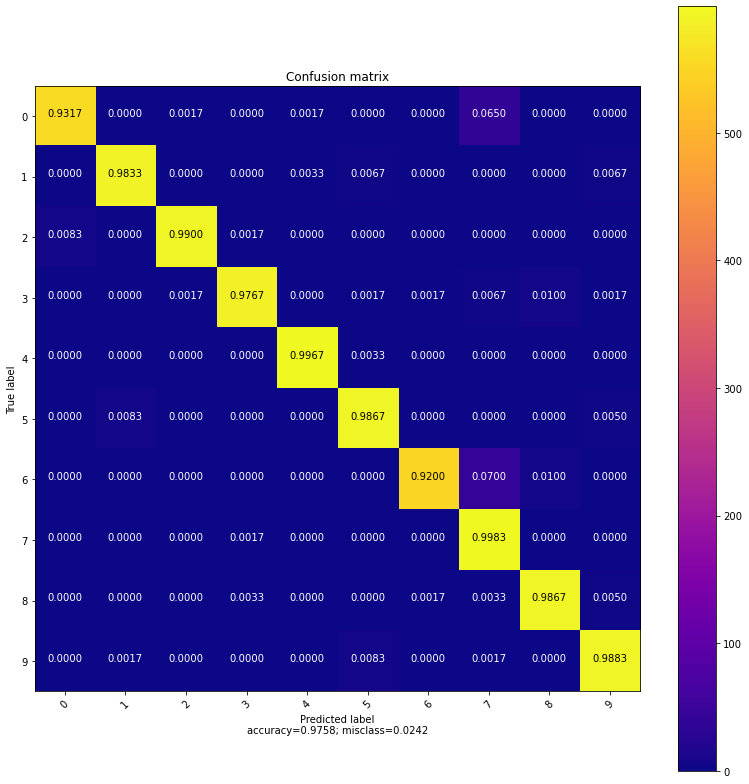

In [26]:
cm = confusion_matrix(y_true=y_val, y_pred=np.argmax(model.predict(X_val), axis=-1))
plot_confusion_matrix(cm, cmap='plasma')

In [27]:
print(model.evaluate(X_test, y_test, verbose=0))

[0.14984332025051117, 0.9798333048820496]
